# Traditional  classification approach
Train knn, decision tree, SVMs
For SVMs use strategies one vs many/many vs many

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from readers_preprocess import read_filter
from time_to_freq_domain import eval_psd_not_modulated

from dim_reduction import  rank_features, pca_data, select_best_chanels
from transformers import flatten_data, transform_to_one_chanel_data
from classification import train_test
from sklearn.decomposition import PCA
%matplotlib notebook


In [2]:


all_paths = [['data_bci\\row_data\\subject1\\'], ['data_bci\\row_data\\subject2\\'],['data_bci\\row_data\\subject3\\']]
columns_to_read =  ['Fp1', 'AF3' ,'F7', 'F3', 'FC1', 'FC5', 'T7', 'C3', 'CP1', 'CP5',
                   'P7', 'P3', 'Pz', 'PO3', 'O1', 'Oz', 'O2', 'PO4', 'P4', 'P8', 'CP6',
                   'CP2', 'C4', 'T8', 'FC6', 'FC2', 'F4', 'F8', 'AF4', 'Fp2', 'Fz', 'Cz','class']

test_subject = '03'#evaluate on the 3rd session
train_subjects = ['01','02']#train on 1st and 2nd sessions


chanels_rank =  [25,  4,  9, 26, 30, 11,  7]#chanel selection precedure, selected chanels indexes

num_perseg = 128
num_overlap = 64
freq=512
min_freq = 8
max_freq = 45
classification_report = []
pca_n_components = []
for path in all_paths:
    cutoff_beggining = 0
    seq_len = 0
    cut_step = 0
    train_data, _, train_anots, test_data, _, test_annoations = read_filter(path, train_subjects, test_subject, columns_to_read, cutoff_beggining, seq_len, cut_step)
    seq_len = freq
    cut_step = int(seq_len/2)
    window_train_data, _, window_train_anots, window_test_data, _, window_test_annoations = read_filter(path, train_subjects, test_subject, columns_to_read, cutoff_beggining, seq_len, cut_step)
   

    y_train = train_anots
    y_test = window_test_annoations
        
    X_train =  eval_psd_not_modulated(train_data, num_perseg, num_overlap, freq, min_freq, max_freq)
    X_test =  eval_psd_not_modulated(window_test_data, num_perseg, num_overlap, freq, min_freq, max_freq)
        
    X_train = flatten_data(X_train[:,:,chanels_rank])
    X_test = flatten_data(X_test[:,:,chanels_rank]) 
        
    most_important_features = rank_features(X_train, y_train)
        
    X_train = X_train[:, most_important_features]
    X_test = X_test[:, most_important_features]
    pca_n_components.append(PCA().fit(X_train).explained_variance_ratio_)

    pca = PCA(n_components=0.985)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    max_el = X_train.max()
    min_el = X_train.min()
    X_train = (X_train-min_el)/(max_el-min_el)
    X_test = (X_test-min_el)/(max_el-min_el)
    
    report, algorithams_names = train_test(X_train, X_test, y_train, y_test)
    classification_report.append(report)


RBF SVM 
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.12, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.663043478261
linear SVM 
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.678260869565
KNN Euclidian
0.632608695652
DT
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
0.586956521739
RBF SVM 
SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma

In [3]:
maxlen = max(len(lst) for lst in pca_n_components)
explained_vars = [np.cumsum(var) for var in pca_n_components]
sumlist = [sum([lst[i] if i<len(lst) else 1 for lst in explained_vars]) for i in range(maxlen)]
mean_vars = np.array(sumlist)/3
mean_vars

array([ 0.87792554,  0.93217271,  0.96043107,  0.97804326,  0.9890892 ,
        0.9928422 ,  0.9955653 ,  0.99751026,  0.99856111,  0.9992549 ,
        0.99967722,  0.99985628,  0.99995446,  1.        ])

[Text(0,0.5,'mean explained variance ratio'), Text(0.5,0,'Component')]

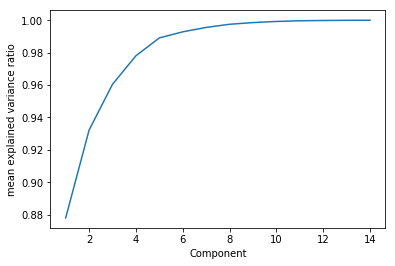

In [4]:

fig, ax = plt.subplots()
ax.plot(range(1, len(mean_vars)+1), mean_vars)

ax.set(xlabel='Component', ylabel='mean explained variance ratio')

In [5]:
alghortihams_results = pd.DataFrame(classification_report, columns=algorithams_names).T

alghortihams_results.columns = ['person_1_accuracy', 'person_2_accuracy', 'person_3_accuracy']
alghortihams_results.index.name = 'algoritham'

means = alghortihams_results.mean(axis=1)
stds = alghortihams_results.std(axis=1)

alghortihams_results['mean_accuracy'] = means
alghortihams_results['std_accuracy'] = stds
alghortihams_results = alghortihams_results.round(3)

alghortihams_results.to_excel("Multiclass_ML_accuracies.xlsx")
alghortihams_results

,person_1_accuracy,person_2_accuracy,person_3_accuracy,mean_accuracy,std_accuracy
algoritham,,,,,
RBF SVM,0.663,0.476,0.513,0.551,0.099
linear SVM,0.678,0.471,0.509,0.553,0.110
KNN Euclidian,0.633,0.500,0.504,0.546,0.075
Decision tree,0.587,0.414,0.438,0.479,0.094
